In [3]:
import numpy as np
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [4]:
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
import sqlalchemy

# connect to the db
dbname = "bde"
port = "5432"
host = "yuma.hpc.nrel.gov"
user = "rlops"
# read the password from a file
passwd_file = '/projects/rlmolecule/rlops_pass'
with open(passwd_file, 'r') as f:
    passwd = f.read().strip()

drivername = "postgresql+psycopg2"
engine_str = f'{drivername}://{user}:{passwd}@{host}:{port}/{dbname}'
engine = sqlalchemy.create_engine(engine_str, execution_options={"isolation_level": "AUTOCOMMIT"})

Session.configure(bind=engine)
session = Session()

In [16]:
run_id = 'stable_radical_optimization_psj_NO_l'

df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)

# df_rewards['smiles'] = df_rewards.data.apply(lambda x: x['smiles'])

In [18]:
df_data = pd.DataFrame(df_rewards.data.tolist())

In [20]:
import rdkit
from tqdm import tqdm
tqdm.pandas()

smarts = rdkit.Chem.MolFromSmarts('C(-[CH3])(-[CH3])-[NR1](-[OX1])-C(-[CH3])(-[CH3])')
has_match = df_data.smiles.progress_apply(lambda x: rdkit.Chem.MolFromSmiles(x).HasSubstructMatch(smarts))

100%|██████████| 1588333/1588333 [01:35<00:00, 16641.59it/s]


In [22]:
matching_mols = df_data[has_match]

In [32]:
matching_mols.ionization_energy = matching_mols.ionization_energy.astype(float)
matching_mols.electron_affinity = matching_mols.electron_affinity.astype(float)

/home/pstjohn/mambaforge/envs/rlmol39/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [34]:
rdkit.Chem.MolToSmiles(rdkit.Chem.MolFromSmiles('CC1(CCCC(N1[O])(C)C)C'))

'CC1(C)CCCC(C)(C)N1[O]'

In [39]:
matching_mols[(matching_mols.smiles == 'CC1(C)CCCC(C)(C)N1[O]')]

,forced_terminal,smiles,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff,status
905715,True,CC1(C)CCCC(C)(C)N1[O],0.4325937,44.226597,0.655321,-0.906452,70.67363,27.231148,NaN


In [44]:
matching_mols['num_atoms'] = matching_mols.smiles.apply(lambda x: rdkit.Chem.MolFromSmiles(x).GetNumAtoms())

<ipython-input-44-9f3983ef4601>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_mols['num_atoms'] = matching_mols.smiles.apply(lambda x: rdkit.Chem.MolFromSmiles(x).GetNumAtoms())


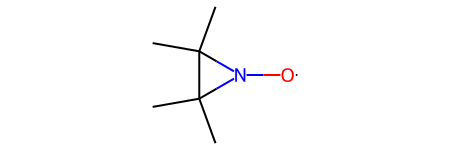

In [47]:
rdkit.Chem.MolFromSmiles('CC1(C)N([O])C1(C)C')

In [46]:
matching_mols.sort_values('num_atoms')

,forced_terminal,smiles,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff,status,num_atoms
10324,True,CC1(C)N([O])C1(C)C,0.5150662,34.521122,1.074589,-0.571184,76.925575,21.154953,NaN,8
158107,True,CC1(C)CC(C)(C)N1[O],0.55964375,57.38359,0.608741,-0.853498,69.14035,31.203545,NaN,9
883832,True,CC1(C)CNC(C)(C)N1[O],0.46587995,62.338024,0.332900,-1.067056,66.565704,25.671349,NaN,10
903440,True,CC1(C)CCC(C)(C)N1[O],0.4417901,63.296093,0.331761,-1.112120,64.29387,31.910805,NaN,10
904899,True,CC1(C)C=CC(C)(C)N1[O],0.45173886,62.29113,0.503483,-1.069426,65.471115,35.347206,NaN,10
...,...,...,...,...,...,...,...,...,...,...
1405348,True,CC(=O)O[C@H]1C(=O)C(C)(C)N([O])C1(C)C,0.4635407,63.709034,0.920552,-0.643198,66.5502,21.358086,NaN,15
1405338,True,CSC1=C(OC=O)C(C)(C)N([O])C1(C)C,0.5074766,62.058342,0.650511,-0.849695,66.47777,28.143433,NaN,15
1405334,True,CCC(=S)C(O)=C1C(C)(C)N([O])C1(C)C,0.56913626,59.849983,0.758608,-0.265816,68.504906,15.234299,NaN,15
1406631,True,CC1(C)C=C(C(N)=C(N)N)C(C)(C)N1[O],0.47851345,63.259007,-0.274210,-1.156702,65.99741,11.445702,NaN,15


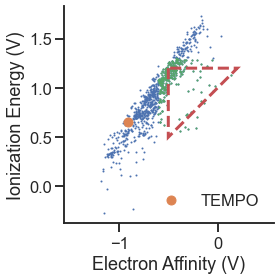

In [67]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.set_adjustable('datalim')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))

ax.plot(matching_mols.electron_affinity, matching_mols.ionization_energy, '.', ms=2)


to_calc = matching_mols[(matching_mols.ionization_energy < 1.3) &
                        (matching_mols.ionization_energy > .4) & 
                        (matching_mols.electron_affinity > -.6)]


ax.plot(to_calc.electron_affinity, to_calc.ionization_energy, 'g.', ms=2)


ax.plot(-0.906452, 0.655321, 'o', label='TEMPO')

ax.set_xlabel('Electron Affinity (V)')
ax.set_ylabel('Ionization Energy (V)')
ax.legend()

sns.despine()
fig.tight_layout()

# ax1.set_xlim([-1.5, 1.5])
# ax1.set_ylim([-1, 2])

<AxesSubplot:ylabel='Frequency'>

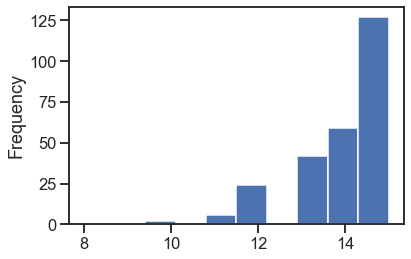

In [63]:
to_calc.sort_values('num_atoms').num_atoms.plot.hist()

In [84]:
matching_mols.to_csv('/projects/rlmolecule/pstjohn/tempo/tempo_predictions.csv', index=False)

In [70]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image

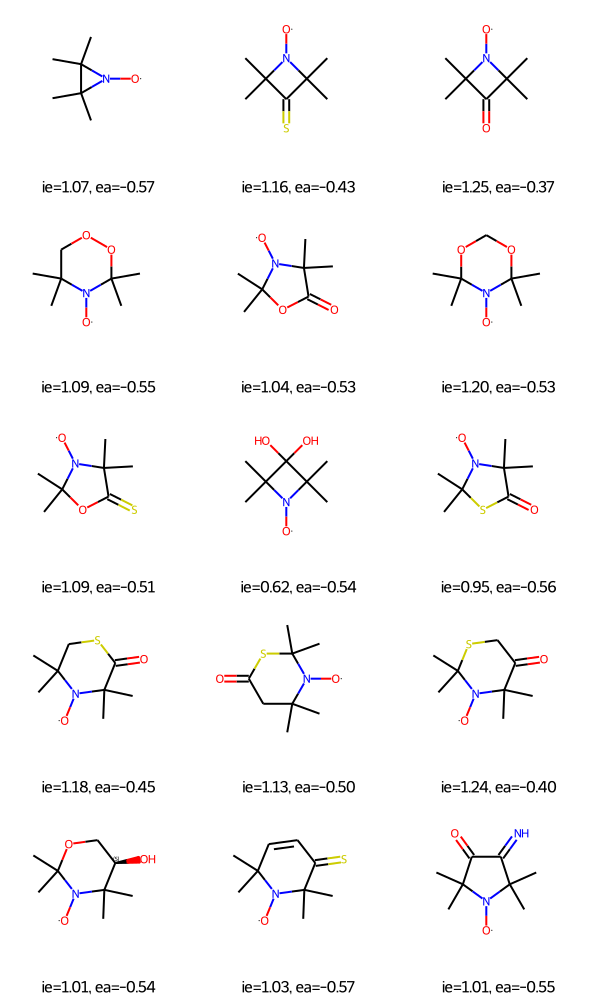

In [73]:
to_plot = to_calc.sort_values('num_atoms').head(20)

mols = list(to_plot.smiles.apply(rdkit.Chem.MolFromSmiles))
d2d = rdMolDraw2D.MolDraw2DCairo(200*3,200*5,200,200)
d2d.drawOptions().fixedBondLength=5
d2d.drawOptions().addStereoAnnotation=True
d2d.DrawMolecules(mols, legends=[f'ie={row.ionization_energy:.2f}, ea={row.electron_affinity:.2f}' for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
Image(d2d.GetDrawingText())

In [78]:
mols_for_dft = to_calc.sort_values('num_atoms').smiles.tolist()

In [ ]:
mols_for_dft

In [85]:
pd.Series(['CC1(C)CC(C)(C)N1[O]', 'CC1(C)CCC(C)(C)N1[O]', 'CC1(C)CCCC(C)(C)N1[O]'] + mols_for_dft
         ).to_csv('/projects/rlmolecule/pstjohn/tempo/to_calc.csv', index=False)